In [170]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import keras_ocr
import os
import io
    
from google.cloud import vision
from pytesseract import Output
from pytesseract import pytesseract as pt
from PIL import Image, ImageDraw
from glob import glob

In [174]:
fold_path = os.getenv('HOME')+'/aiffel/ocr_python/card/'
os.listdir(fold_path)

['card_3.jpeg',
 'images.jpeg',
 'card_8.jpeg',
 'images (3).jpeg',
 'images (8).jpeg',
 'student-school-id-card-1.png',
 'card_1.jpeg',
 'download.jpeg',
 'images (7).jpeg',
 'images (6).jpeg',
 'images (1).jpeg',
 'card_9.jpeg',
 'images (4).jpeg',
 'images (5).jpeg',
 'card_4.png',
 'card_2.jpeg',
 'images (2).jpeg',
 'card_7.jpeg',
 'download (2).jpeg',
 'download (1).jpeg']

In [175]:
def changeName(path, cName):
    i = 1
    for filename in os.listdir(path):
        os.rename(path+filename, path+str(cName)+'_'+str(i)+'.jpeg')
        i += 1

In [176]:
changeName(fold_path, 'StudentID')

images_path = glob(fold_path+'*.jpeg')
images_path

['/home/aiffel0042/aiffel/ocr_python/card/StudentID_15.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/StudentID_1.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/StudentID_7.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/StudentID_8.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/StudentID_16.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/StudentID_18.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/StudentID_12.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/StudentID_4.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/StudentID_14.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/StudentID_11.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/StudentID_13.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/StudentID_2.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/StudentID_10.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/StudentID_5.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/StudentID_20.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/StudentID_9.jpeg',
 '/home/aiffel0

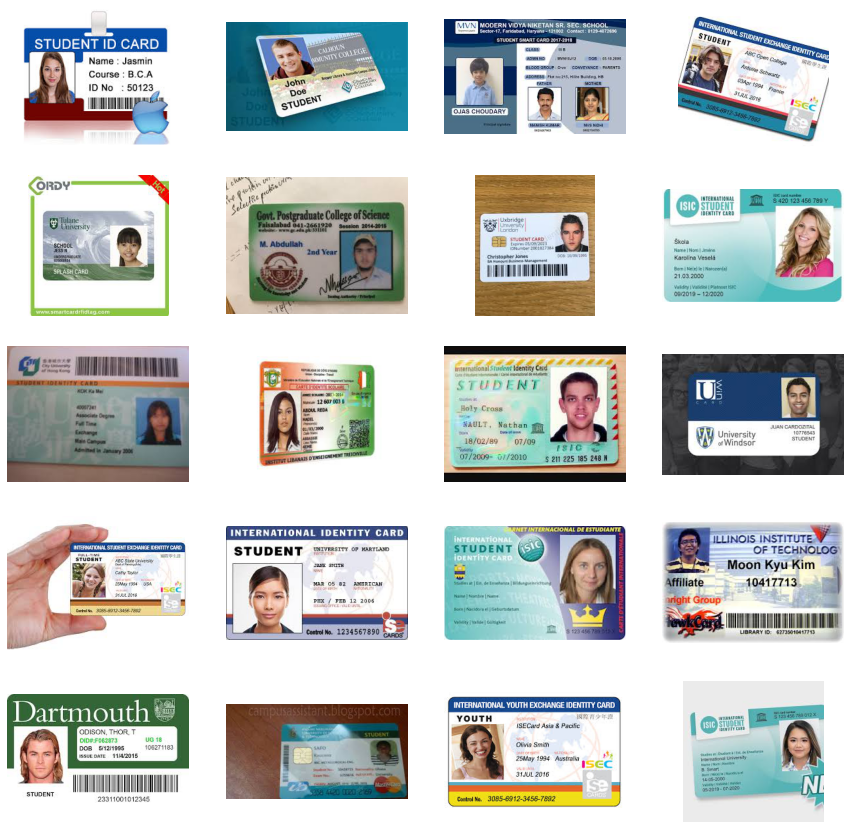

In [180]:
plt.figure(figsize=(15, 15))

for idx, image in enumerate(images_path):
    plt.subplot(5, 4, idx+1)
    im=img.imread(image)
    plt.imshow(im)
    plt.axis('off')

## OCR API

In [181]:
def draw_boxes(image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        draw.polygon([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], None, color)
    return image

In [182]:
def detect_text(path):
    """Detects text in the file."""
    text_dec = []
    bounds = []
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    s = os.path.splitext(path)
    s = os.path.split(s[0])
    name = s[1]
    
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations

    for text in texts:
        text_dec.append(text.description.replace('\n',''))
        vertices = text.bounding_poly
        bounds.append(vertices)
    
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
    return name, text_dec, bounds

In [183]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

ocr_img = []
ocr_dict = {}
# 입력 이미지 경로를 지정해 주세요.
path = '/home/aiffel0042/aiffel/ocr_python/card/card_3.jpeg'

# # 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for path in images_path:
    name, text_dec, bounds = detect_text(path)
    ocr_dict[name] = text_dec
    image = Image.open(path)
    draw_boxes(image, bounds, 'blue')
    ocr_img.append(image)

-rw-r--r-- 1 aiffel0042 aiffel0042 2346 10월  7 10:41 /home/aiffel0042/aiffel/ocr_python/my_google_api_key.json


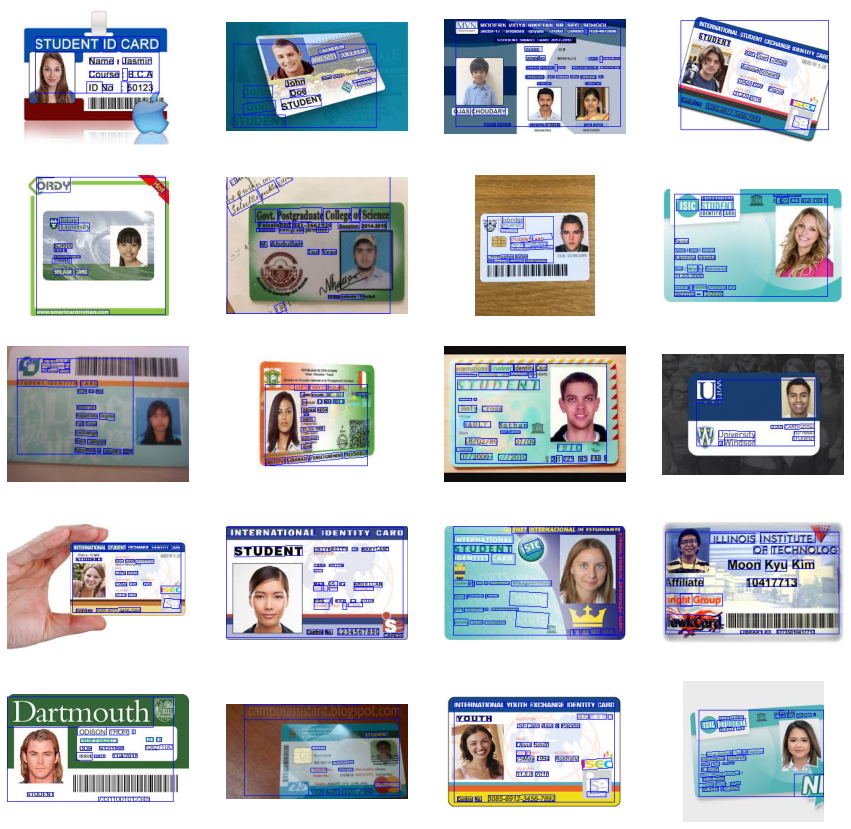

In [184]:
plt.figure(figsize=(15, 15))

for idx, img in enumerate(ocr_img):
    plt.subplot(5, 4, idx+1)
    plt.imshow(img)
    plt.axis('off')

## keras-ocr

In [185]:
# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5
Looking for /home/aiffel0042/.keras-ocr/crnn_kurapan.h5


In [ ]:
images = [ keras_ocr.tools.read(im) for im in images_path]
predictions = [pipeline.recognize([im]) for im in images_path]

# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(100, 100))

for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=predictions[idx][0], ax=ax)

## Tesseract

In [85]:
def crop_word_regions(image_path, output_path):
    s = os.path.splitext(image_path)
    s = os.path.split(s[0])
    name = s[1]
    output_path = output_path + name +'/'
    
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 11'
    image = Image.open(image_path)
    img = cv2.imread(image_path)
    
    d = pt.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    top_level = max(d['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(d['level'])):
        level = d['level'][i]
    
        if level == top_level:
            left = d['left'][i]
            top = d['top'][i]
            width = d['width'][i]
            height = d['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return name, cropped_image_path_list, img


work_dir = os.getenv('HOME')+'/aiffel/ocr_python/card'
output_path = work_dir + '/output/' 

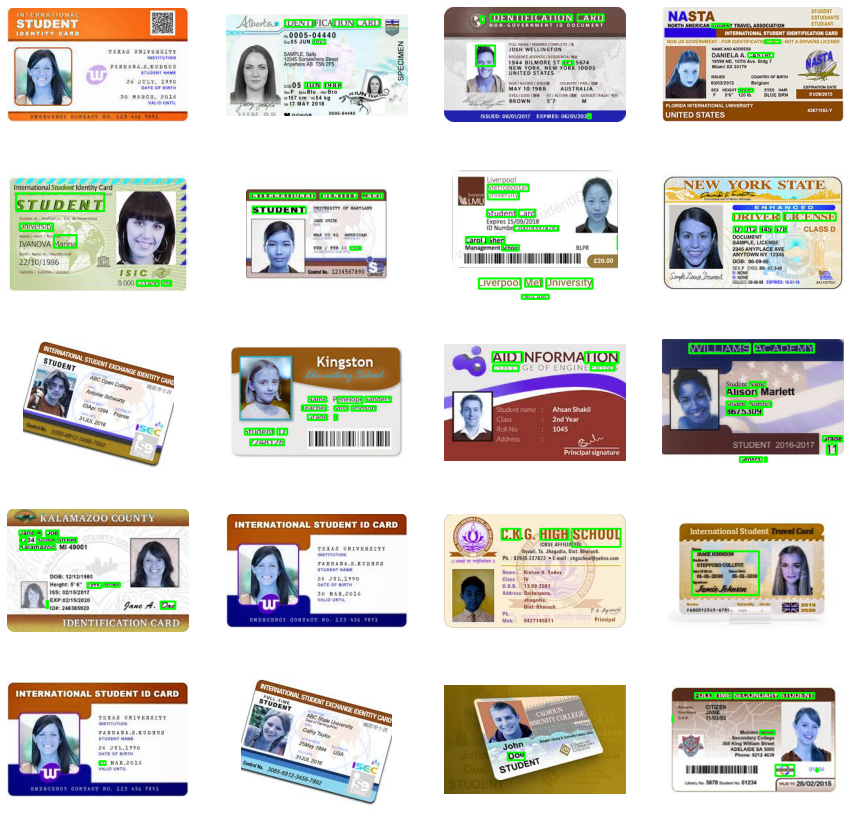

In [90]:
Tesser_dict = {}
img_dict = {}
plt.figure(figsize=(15, 15))

for idx, path in enumerate(images_path):    
    name, cropped_image_path_list, imgs = crop_word_regions(path, output_path)
    Tesser_dict[name] = cropped_image_path_list
    img_dict[name] = imgs
    plt.subplot(5, 4, idx+1)
    plt.imshow(imgs)
    plt.axis('off')
plt.savefig(work_dir + '/test/13')

['Liverpool', 'Metroooitan', 'ee', 'University', 'Student', 'Card', '2018', 'cxpires 1', 'ID Numie', 'wit tec re re.', 'Management', 'School', 'Carol J', 'Shen', 'BL Pe', '', 'TM', 'TH', 'WU', 'Liverpool', 'Viet', 'University', 'etst MF']
Done


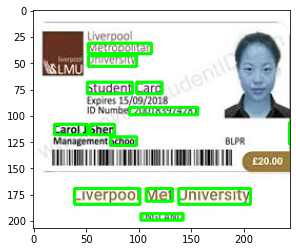

In [99]:
def recognize_images(cropped_image_path_list):
    test = []
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pt.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        test.append(recognized_data['text'].replace('\n', '').replace('\x0c',''))
        
    print(test)
    print("Done")

plt.imshow(img_dict['card_17'])
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(Tesser_dict['card_17'])